# Predicting beer consumption
Online class on Supervised Learning, Wednesday, 29th of October 2025

For BIP "Machine Learning for Data Science" by Marieke Bouma & Remi Thüss, Hanze

## Importing required modules

In [66]:
# Install packages for the project
# !pip install pandas numpy seaborn matplotlib scikit-learn scipy networkx tensorflow
# !pip install tensorflow

In [67]:
# Import the required building blocks
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Import your models here for a clean look
# from ... import ...
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import f1_score

# Beer consumption as a classification issue
Let's try to predict whether "very little", "little", "much" or "very much" beer is drunk; A classification.

To this end, the data is processed in which the number of Litres is divided into four classes.
The limit of the classes is roughly based on the quartile distribution.

- I: under 22,000 Litres
- II: between 22,000 and 25,000 Litres
- III: between 25,000 and 29,000 Litres
- IV: More than 29,000 Litres

If all goes well, these classes are of comparable size (i.e. somewhat balanced).

## Data analysis and preprocessing

In [68]:
# Back to the source
df = pd.read_csv('Beerconsumption.csv')
df.dropna(inplace=True)
df.Date = pd.to_datetime(df.Date)
df.Weekend = df.Weekend.astype(int)

### Making classes

In [69]:
# Making the classes (this is one method, many exist)
df['Class1'] = np.where(df['Litres'] > 29000, 1, 0)
df['Class2'] = np.where(df['Litres'] > 25000, 1, 0)
df['Class3'] = np.where(df['Litres'] > 22000, 1, 0)
df['Class4'] = np.where(df['Litres'] > 10000, 1, 0)

df['Class'] = df.Class1 + df.Class2 + df.Class3 + df.Class4
df.head()

,Date,AvgTemp,MinTemp,MaxTemp,Rainfall_mm,Weekend,Litres,Class1,Class2,Class3,Class4,Class
0,2015-01-01,27.30,23.9,32.5,0.0,0,25461.0,0,1,1,1,3
1,2015-01-02,27.02,24.5,33.5,0.0,0,28972.0,0,1,1,1,3
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814.0,1,1,1,1,4
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799.0,1,1,1,1,4
4,2015-01-05,23.82,21.0,28.3,0.0,0,28900.0,0,1,1,1,3


In [70]:
# The auxiliary columns can leave again
df.drop(columns=['Class1', 'Class2', 'Class3', 'Class4'], inplace=True)
df.head()

,Date,AvgTemp,MinTemp,MaxTemp,Rainfall_mm,Weekend,Litres,Class
0,2015-01-01,27.30,23.9,32.5,0.0,0,25461.0,3
1,2015-01-02,27.02,24.5,33.5,0.0,0,28972.0,3
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814.0,4
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799.0,4
4,2015-01-05,23.82,21.0,28.3,0.0,0,28900.0,3


      Litres                                                       
       count        sum     mean     std      min   median      max
Class                                                              
1         90  1808614.0  20095.7  1672.7  14343.0  20597.5  21979.0
2         98  2309777.0  23569.2   942.3  22001.0  23551.5  24974.0
3         95  2560159.0  26949.0  1163.6  25070.0  26828.0  28979.0
4         82  2592949.0  31621.3  1985.8  29090.0  31134.0  37937.0


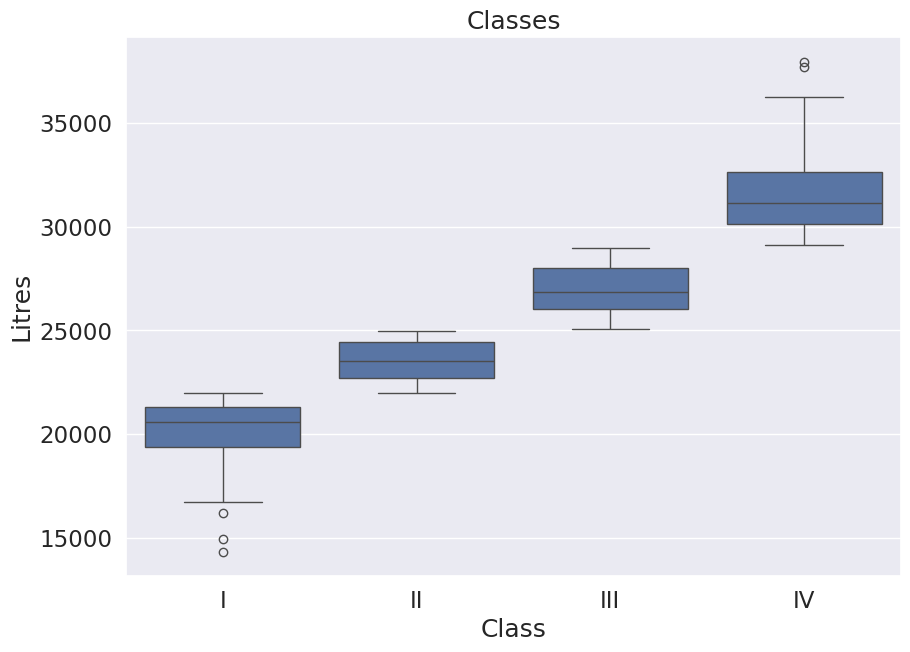

In [71]:
# Just a check of the number of Litres per class
perClass = df.groupby('Class').agg({'Litres':['count','sum','mean','std','min','median', 'max']}).round(1)
print(perClass)

plt.figure(figsize=(10,7))
sns.boxplot(x="Class", y="Litres", data=df)
plt.xticks(range(0,4),["I", "II", "III", "IV"])
plt.title("Classes")
plt.show()

### 1. Feature selection
Is the Date a useful feature for our goal? Would another be useful? How can you check?

In [72]:
# Let's add the season, because why not
df['Season'] = df.Date.dt.month.map({1:1, 2:1, 3:2, 4:2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4, 12:1})

In [73]:
df['Season'].unique()

array([1, 2, 3, 4])

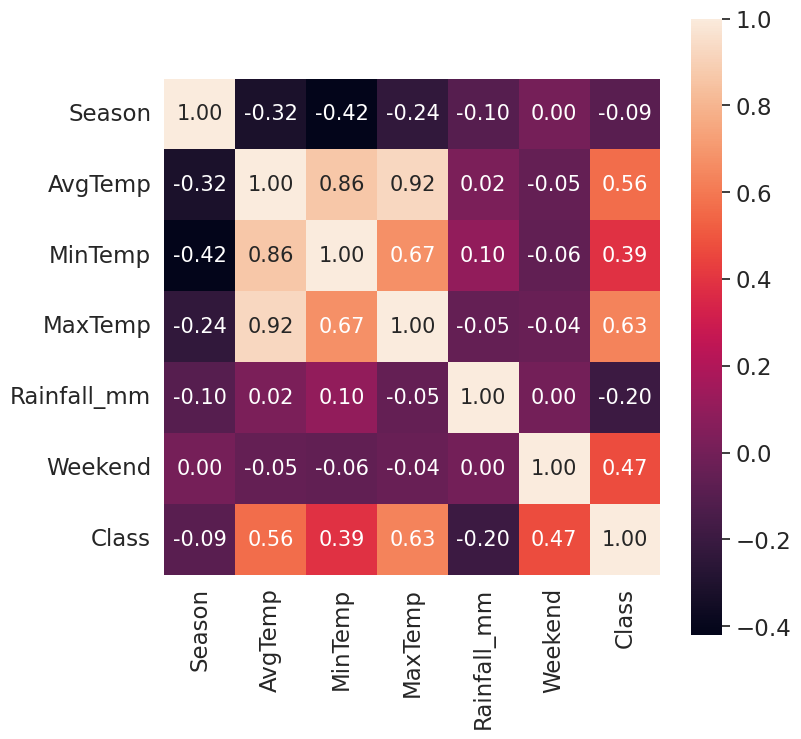

In [74]:
# Plot the correlation matrix for all features except the date
kolomdf = ['Season', 'AvgTemp', 'MinTemp', 'MaxTemp', 'Rainfall_mm', 'Weekend', 'Class']

feature_names = kolomdf[:-1]  # Exclude 'Class' for feature names

plt.figure(figsize=(8,8))
cm = np.corrcoef(df[kolomdf].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=kolomdf,
                xticklabels=kolomdf
                )
plt.show()

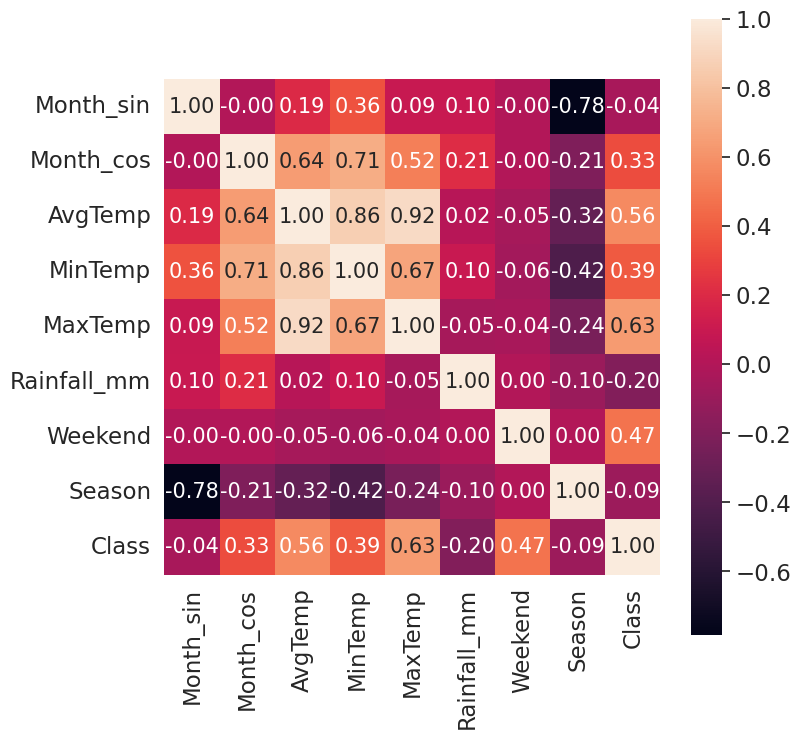

In [75]:
import numpy as np

# Extract month from the date
df['Month'] = df['Date'].dt.month

# Cyclical encoding: preserves continuity (January and December are close)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

features_and_target = ['Month_sin', 'Month_cos', 'AvgTemp', 'MinTemp', 'MaxTemp', 'Rainfall_mm', 'Weekend', 'Season', 'Class']
plt.figure(figsize=(8,8))
cm = np.corrcoef(df[features_and_target].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=features_and_target,
                xticklabels=features_and_target
                )
plt.show()


We'll make a simple model, using only MaxTemp and Weekend as features. AvgTemp and MinTemp are too strongly correlated with MaxTemp, and Rainfall and Season are only very weakly correlated with Class.

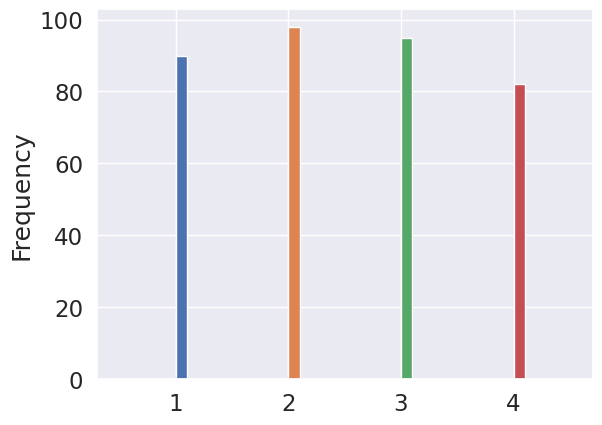

In [95]:
# We'll use as the predictors/features/independent variables MaxTemp and Weekend,
# and the class is the value to be predicted (label/independent var)
labels = df.loc[:,'Class']
data = df.loc[:,['MaxTemp', 'Weekend', 'Month_sin', 'Month_cos']]
# data = df.loc[:, feature_names]  # Using all features except 'Class'

# Insight into the frequency distribution of the classes;
# They are roughly balanced (as intended)
labels[:].groupby(labels[:]).plot(kind="hist")
plt.show()

## 2. Baseline models for classification
Code a baseline model

In [96]:
# splits the dataset in a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=0)


# give the size of the training and the test set again
print('shape of training set: ', X_train.shape)
print('shape of test set:     ', X_test.shape)

shape of training set:  (273, 4)
shape of test set:      (92, 4)


In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 2.1 Choose a baseline classification model, fill in the blank
baseline_1 = LogisticRegression(solver='lbfgs', max_iter=1000)

baseline_1.fit(X_train, y_train)

y_pred = baseline_1.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('accuracy:', acc)


accuracy: 0.5543478260869565


In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 2.1 Choose a baseline classification model, fill in the blank
baseline_1 = KNeighborsClassifier(n_neighbors=5)  # you can adjust n_neighbors

baseline_1.fit(X_train, y_train)

y_pred = baseline_1.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('accuracy:', acc)

accuracy: 0.44565217391304346


#### Question: how do these models compare? Is there a difference in accuracy? Why do you think this is?

## 3/4. Tree-based models
Code a decision tree and random forest below!

In [99]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)

dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

acc = accuracy_score(y_test,y_pred)
print('accuracy: ', acc)

accuracy:  0.5


In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('accuracy:', acc)

accuracy: 0.5869565217391305


#### Challenge: visualise the decision making process
There exist some cool libraries to visualise the decision making process in a tree-based model. Try find these libraries and apply them to one of your models!

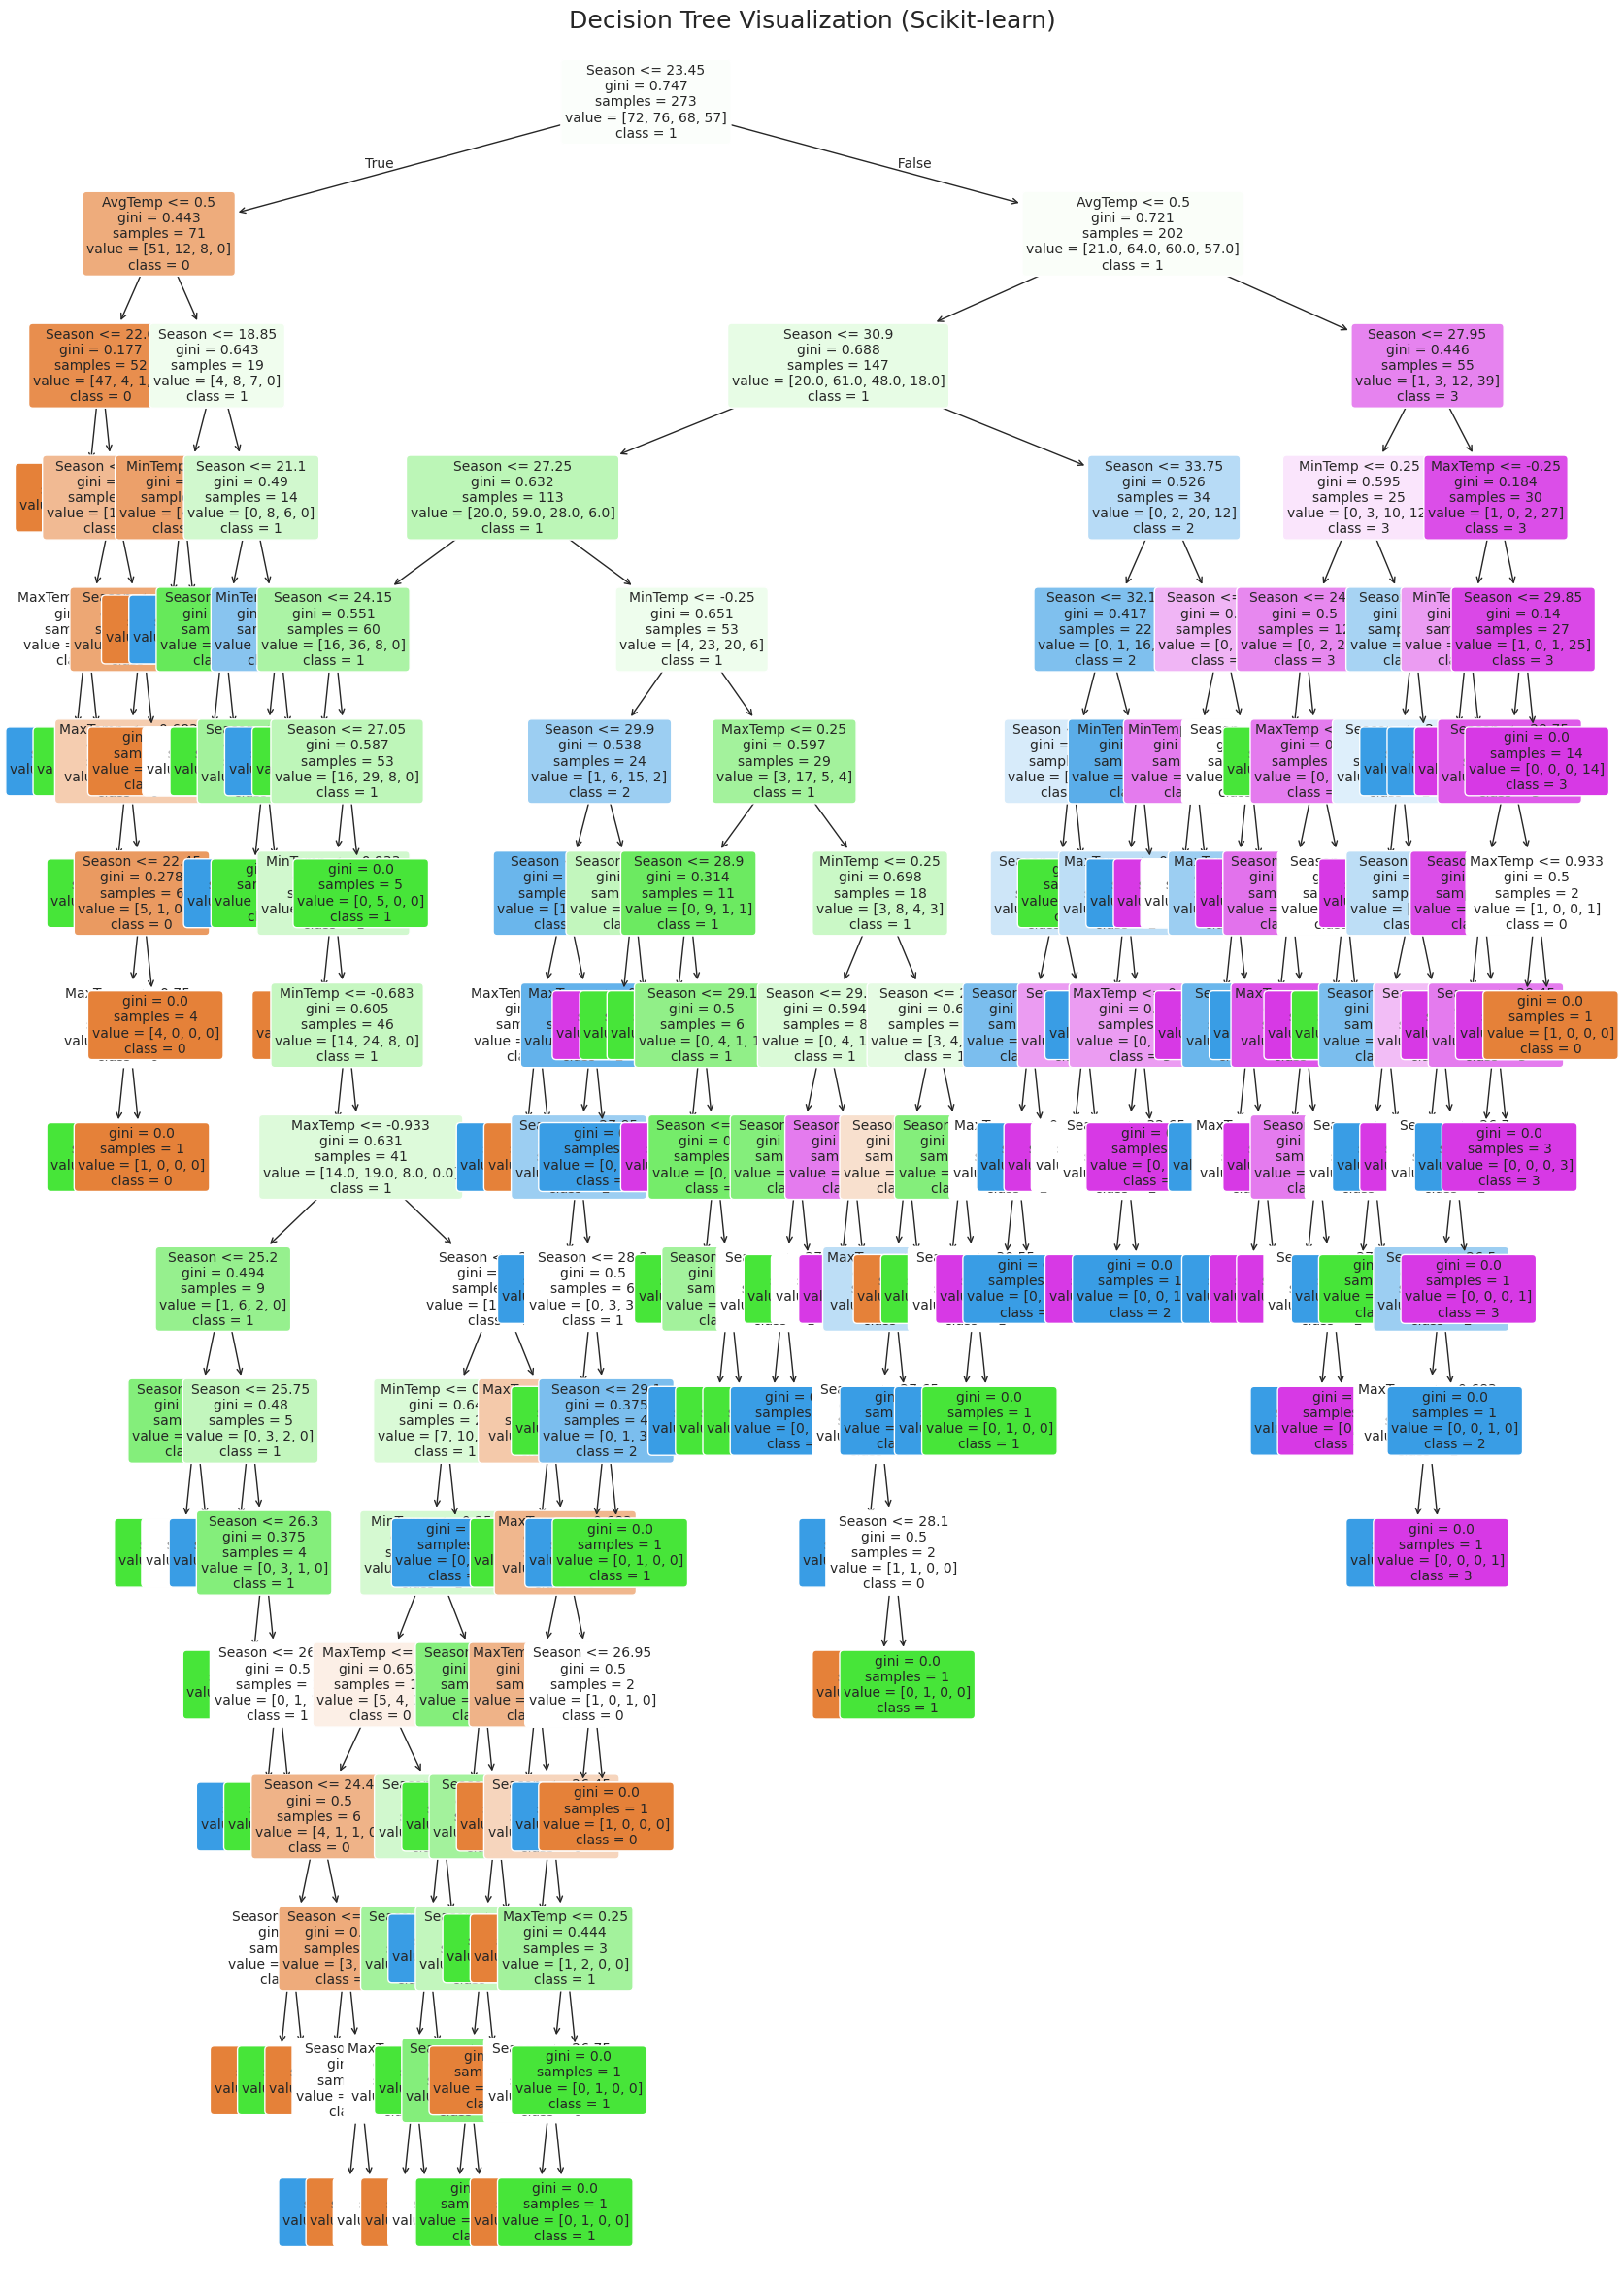

In [100]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import plot_tree

class_names = ['0', '1', '2', '3']

plt.figure(figsize=(20, 30))
plot_tree(
    dt_model,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization (Scikit-learn)")
plt.show()


## 5. Neural networks
Complete the code for a neural network for the beer consumption classification issue!

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

rf_model = LogisticRegression(max_iter=1000,random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('accuracy:', acc)

accuracy: 0.5543478260869565


#### More on neural networks in a later class!

## 6. Metrics (Confusion matrix)
Below you can find some standard code to make and visualise a confusion matrix. The score that is usually used is called the F1-score. You will learn more on model evaluation in a later class, but here's a taste!

Use the "classification report" code to calculate the F1-scores of all of your models*. How well do they perform? Do the F1-score and accuracy differ?

*excluding the neural network, because it already shows the F1-score.

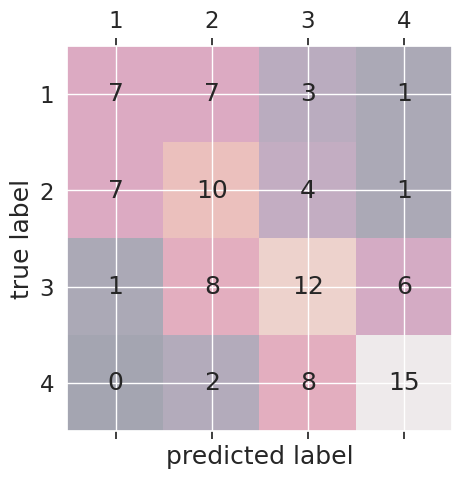

In [85]:
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)

#image for confusion matrix
fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(confmat, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
                s=confmat[i, j],
                fontsize=18,
                va='center', ha='center')
ticks = labels.unique()
ticks.sort()
ax.set_xticks(np.arange(confmat.shape[0]), labels=ticks)
ax.set_yticks(np.arange(confmat.shape[1]), labels=ticks)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.47      0.39      0.42        18
           2       0.37      0.45      0.41        22
           3       0.44      0.44      0.44        27
           4       0.65      0.60      0.62        25

    accuracy                           0.48        92
   macro avg       0.48      0.47      0.48        92
weighted avg       0.49      0.48      0.48        92



In [87]:
# [your code to compare the accuracy and f1-score for each model here]

[your analysis here]